In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
    
import ray
from ray.rllib.algorithms.ppo import PPOConfig

from src.parsers import HMParser
from src.resources import Aggregator, Generator, Load, Storage, Vehicle
from src.algorithms.rl import EnergyCommunitySequentialV0

2024-03-02 23:14:15,499	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

data = HMParser(file_path='/Users/ecgomes/DataspellProjects/pyecom/data/EC_V4.xlsx', ec_id=1)
data.parse()

In [3]:
# Define resources

resources = []

# Add the generators
for i in range(data.generator['p_forecast'].shape[0]):
    resources.append(Generator(name='generator_{:02d}'.format(i+1),
                               value=np.zeros(data.generator['p_forecast'][i].shape),
                               lower_bound=np.zeros(data.generator['p_forecast'][i].shape),
                               upper_bound=data.generator['p_forecast'][i],
                               cost=data.generator['cost_parameter_b'][i],
                               cost_nde=data.generator['cost_nde'][i],
                               is_renewable=data.generator['type_generator'][i]))

# Add the loads
for i in range(data.load['p_forecast'].shape[0]):
    resources.append(Load(name='load_{:02d}'.format(i+1),
                          value=data.load['p_forecast'][i],
                          lower_bound=np.zeros(data.load['p_forecast'][i].shape),
                          upper_bound=data.load['p_forecast'][i],
                          cost=np.ones(data.load['p_forecast'][i].shape),
                          cost_cut=data.load['cost_cut'][i],
                          cost_reduce=data.load['cost_reduce'][i],
                          cost_ens=data.load['cost_ens'][i]))
    
# Add the storage
for i in range(data.storage['p_charge_limit'].shape[0]):
    resources.append(Storage(name='storage_{:02d}'.format(i+1),
                             value=data.storage['initial_state'][i] * np.ones(data.storage['p_charge_limit'].shape[1]),
                             lower_bound=np.ones(data.storage['p_charge_limit'].shape[0]) * data.storage['energy_min_percentage'][i],
                             upper_bound=(data.storage['energy_capacity'] * 
                                          np.ones(data.storage['p_charge_limit'].shape[0])),
                             cost=np.ones(data.storage['p_charge_limit'].shape[0]),
                             cost_discharge=data.storage['discharge_price'][i],
                             cost_charge=data.storage['charge_price'][i],
                             capacity_max=data.storage['energy_capacity'][i],
                             capacity_min=data.storage['energy_min_percentage'][i],
                             initial_charge=data.storage['initial_state'][i],
                             discharge_efficiency=data.storage['discharge_efficiency'][i],
                             discharge_max=data.storage['p_discharge_limit'][i],
                             charge_efficiency=data.storage['charge_efficiency'][i],
                             charge_max=data.storage['p_charge_limit'][i],
                             capital_cost=np.array([0.05250, 0.10500, 0.01575])))
    
# Define the Electric Vehicles
for i in np.arange(data.vehicle['e_capacity_max'].shape[0]):
    new_ev = Vehicle(name='ev_{:02d}'.format(i + 1),
                     value=data.vehicle['min_technical_soc'][i] * np.ones(data.vehicle['schedule_charge'][i, :].shape),
                     lower_bound=np.ones(data.vehicle['schedule_charge'][i].shape) * \
                                 data.vehicle['min_technical_soc'][i] * data.vehicle['e_capacity_max'][i],
                     upper_bound=np.ones(data.vehicle['schedule_charge'][i].shape) * \
                                 data.vehicle['e_capacity_max'][i],
                     cost = np.zeros(data.vehicle['schedule_charge'][i].shape),
                     cost_discharge=np.ones(data.vehicle['schedule_charge'][i].shape) * \
                                    data.vehicle['discharge_price'][i, 0],
                     cost_charge=np.ones(data.vehicle['schedule_charge'][i].shape) * \
                                 data.vehicle['charge_price'][i, 0],
                     capacity_max=data.vehicle['e_capacity_max'][i],
                     initial_charge=data.vehicle['min_technical_soc'][i],
                     min_charge=data.vehicle['min_technical_soc'][i] * data.vehicle['e_capacity_max'][i],
                     discharge_efficiency=data.vehicle['charge_efficiency'][i],
                     charge_efficiency=data.vehicle['charge_efficiency'][i],
                     schedule_connected=data.vehicle['schedule'][i],
                     schedule_discharge=data.vehicle['schedule_discharge'][i],
                     schedule_charge=data.vehicle['schedule_charge'][i],
                     schedule_requirement_soc=data.vehicle['schedule_departure_soc'][i],
                     schedule_arrival_soc=data.vehicle['schedule_arrival_soc'][i]
                     )
    resources.append(new_ev)
    
# Append Aggregator
resources.append(Aggregator(name='aggregator',
                            value=np.zeros(data.load['p_forecast'][0, :].shape),
                            lower_bound=np.zeros(data.load['p_forecast'][0, :].shape),
                            upper_bound=data.peers['import_contracted_p_max'][0, :],
                            cost=data.peers['buy_price'][0, :],
                            imports=np.zeros(data.load['p_forecast'][0, :].shape),
                            exports=np.zeros(data.load['p_forecast'][0, :].shape),
                            import_cost=data.peers['buy_price'][0, :],
                            export_cost=data.peers['sell_price'][0, :],
                            import_max=data.peers['import_contracted_p_max'][0, :],
                            export_max=data.peers['export_contracted_p_max'][0, :]))

In [4]:
# Create the environment and check if everything is ok

temp_env = EnergyCommunitySequentialV0(resources=resources,
                                       import_penalty=1000,
                                       export_penalty=1000,
                                       storage_action_penalty=500,
                                       ev_action_penalty=500,
                                       ev_requirement_penalty=700,
                                       balance_penalty=1000)
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
while not terminations['__all__'] and not truncations['__all__']:
    actions = temp_env.action_space.sample()
    observations, rewards, terminations, truncations, infos = temp_env.step(actions)
    # print('Observation: {}'.format(observations))
    # print('Observation keys: {}'.format(observations.keys()))
    # print('Reward: {}'.format(rewards))
    # print('Infos: {}\n'.format(infos))
print('Terminated: {}'.format(terminations['__all__']))

Terminated: True


In [5]:
# Check for environment errors

ray.rllib.utils.check_env(env=temp_env)

In [6]:
# Aux function to assign policies

def assign_policies(env):

    policies = {}
    for agent in env.agents:
        policies[agent] = (None,
                           env.observation_space[agent],
                           env.action_space[agent],
                           {})
    return policies

# policies = assign_policies(env=temp_env)

In [7]:
# Create the policies dictionary

def assign_group_policies(env):
    
    policies = {'generator': (None,
                              env.observation_space['generator_01'],
                                env.action_space['generator_01'],
                                {}),
                'storage': (None,
                            env.observation_space['storage_01'],
                            env.action_space['storage_01'],
                            {}),
                'ev': (None,
                       env.observation_space['ev_01'],
                       env.action_space['ev_01'],
                       {}),
                'aggregator': (None,
                               env.observation_space['aggregator'],
                               env.action_space['aggregator'],
                               {})           
                }
    
    return policies

policies = assign_group_policies(env=temp_env)

In [15]:
# Create an RLlib Algorithm instance from a PPOConfig to learn how to
# act in the above environment.

from ray.tune import register_env

ray.shutdown()
ray.init()

IMPORT_PENALTY = 1
EXPORT_PENALTY = 1
STORAGE_ACTION_PENALTY = 100
EV_ACTION_PENALTY = 100
EV_REQUIREMENT_PENALTY = 1000
BALANCE_PENALTY = 500

register_env("EC_Multi", lambda config: EnergyCommunitySequentialV0(resources=resources,
                                                                    import_penalty=IMPORT_PENALTY,
                                                                    export_penalty=EXPORT_PENALTY,
                                                                    storage_action_penalty=STORAGE_ACTION_PENALTY,
                                                                    ev_action_penalty=EV_ACTION_PENALTY,
                                                                    ev_requirement_penalty=EV_REQUIREMENT_PENALTY,
                                                                    balance_penalty=BALANCE_PENALTY),
             )

# Define the PPOConfig
config = PPOConfig()
config = config.environment(env="EC_Multi")
config = config.training(train_batch_size=240,
                         lr=2e-4,
                         gamma=0.99,
                         use_gae=True,
                         use_critic=True)
config = config.framework('torch')
config = config.rollouts(batch_mode='complete_episodes',
                         num_rollout_workers=2,
                         rollout_fragment_length='auto')
config = config.multi_agent(policies=policies,
                            policy_mapping_fn=(lambda agent_id, episode, worker, **kwargs: 
                            'generator' if agent_id.startswith('generator') else
                            'storage' if agent_id.startswith('storage') else
                            'ev' if agent_id.startswith('ev') else
                            'aggregator'))
config = config.exploration(exploration_config={})

# Use the config's `build()` method to construct a PPO object.
algo = config.build()

# Train for n iterations and report results (mean episode rewards).
checkpoint = None
for i in range(500):
    results = algo.train()
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")
    #if results['episode_reward_mean'] > -50.0:
    #    break

    # Save the checkpoint to disk.
    # checkpoint = algo.save()
    # print("checkpoints saved at", checkpoint)

2024-03-02 23:40:54,536	INFO worker.py:1642 -- Started a local Ray instance.
2024-03-02 23:40:55,056	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
2024-03-02 23:40:55,058	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
/Users/ecgomes/DataspellProjects/pyecom/venv/lib/

Iter: 0; avg. reward=-1942703.1930071046
Iter: 1; avg. reward=-1964278.463932688
Iter: 2; avg. reward=-1944975.0177459389
Iter: 3; avg. reward=-1935700.1078890348
Iter: 4; avg. reward=-1894129.3805498679
Iter: 5; avg. reward=-1791555.081771737
Iter: 6; avg. reward=-1720425.0553888702
Iter: 7; avg. reward=-1748524.4285182485
Iter: 8; avg. reward=-1765957.5629005209
Iter: 9; avg. reward=-1755522.7316779997
Iter: 10; avg. reward=-1749639.831924139
Iter: 11; avg. reward=-1761115.37452746
Iter: 12; avg. reward=-1733166.7531327405
Iter: 13; avg. reward=-1744269.9243704423
Iter: 14; avg. reward=-1729776.104994869
Iter: 15; avg. reward=-1716133.4487951878
Iter: 16; avg. reward=-1700040.8552744305
Iter: 17; avg. reward=-1689058.1270107108
Iter: 18; avg. reward=-1700592.6980474174
Iter: 19; avg. reward=-1713674.0274605409
Iter: 20; avg. reward=-1715674.9127397658
Iter: 21; avg. reward=-1727154.9477330304
Iter: 22; avg. reward=-1736916.9004827936
Iter: 23; avg. reward=-1737196.7096730166
Iter: 24

In [16]:
# Check the results
# Create a new env
test_env = EnergyCommunitySequentialV0(resources=resources,
                                       import_penalty=IMPORT_PENALTY,
                                       export_penalty=EXPORT_PENALTY,
                                       storage_action_penalty=STORAGE_ACTION_PENALTY,
                                       ev_action_penalty=EV_ACTION_PENALTY,
                                       ev_requirement_penalty=EV_REQUIREMENT_PENALTY,
                                       balance_penalty=BALANCE_PENALTY)

obs, info = test_env.reset()

# Set up the terminations and truncations
terminations = truncations = {a: False for a in test_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False

# Set up the order of the agents
sequence = test_env._agent_sequence
current_idx = 0
while not terminations['__all__'] and not truncations['__all__']:
    
    current_agent = test_env.agents[sequence[current_idx]]
    
    current_policy = 'generator' if sequence[current_idx].startswith('generator') else \
                     'storage' if sequence[current_idx].startswith('storage') else \
                     'ev' if sequence[current_idx].startswith('ev') else \
                     'aggregator'
    
    action_dict = {current_agent.name: algo.compute_single_action(observation=obs[current_agent.name],
                                                                  policy_id=current_policy)}

    obs, rewards, terminations, truncations, info = test_env.step(action_dict)
    # print('Observation: {}'.format(obs))
    print('Reward: {}'.format(rewards))
    print('Infos: {}\n'.format(info))
    
    current_idx = (current_idx + 1) % len(sequence)

Reward: {}
Infos: {'generator_02': {'value': 0.0}}

Reward: {}
Infos: {'generator_03': {'value': 0.0}}

Reward: {}
Infos: {'generator_04': {'value': 0.0}}

Reward: {}
Infos: {'generator_05': {'value': 0.0}}

Reward: {}
Infos: {'generator_06': {'value': 0.0}}

Reward: {}
Infos: {'generator_07': {'value': 0.0}}

Reward: {}
Infos: {'ev_01': {'current': 0.2, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'ev_02': {'current': 0.2, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'ev_03': {'current': 0.2, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'ev_04': {'current': 0.2, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'ev_05': {'current': 0.2, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'storage_01': {'current': 0.8, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'storage_02': {'current': 0.8, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'storage_03': {'current': 0.8, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {}

Reward: {'g

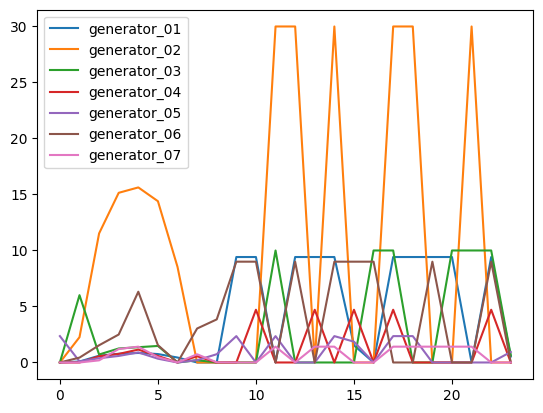

In [24]:
# Plot the generator power output

plt.figure()

for i in range(data.generator['p_forecast'].shape[0]):
    plt.plot(test_env.generators[i].value)
    
plt.legend(['generator_{:02d}'.format(i+1) for i in range(data.generator['p_forecast'].shape[0])])
plt.show()

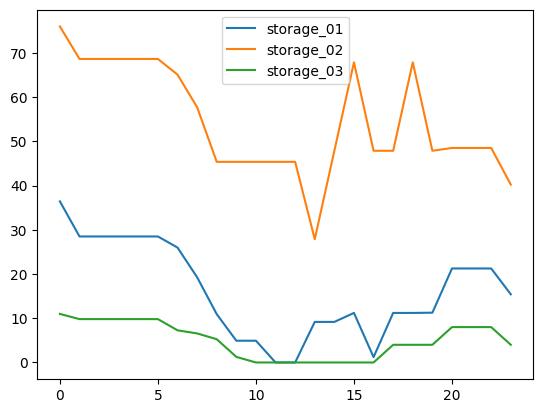

In [25]:
# Plot the storage state of charge

plt.figure()

for i in range(data.storage['p_charge_limit'].shape[0]):
    plt.plot(test_env.storages[i].value * test_env.storages[i].capacity_max)
    
plt.legend(['storage_{:02d}'.format(i+1) for i in range(data.storage['p_charge_limit'].shape[0])])
plt.show()

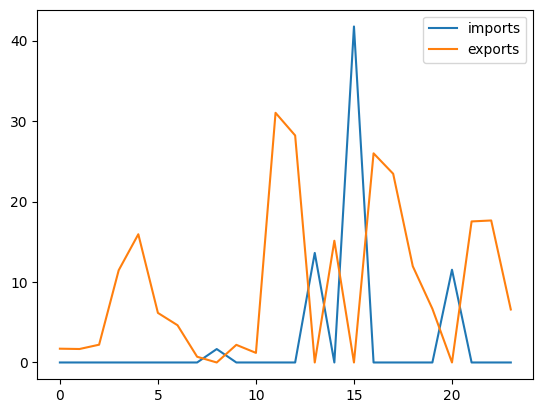

In [26]:
# Check imports and exports

plt.figure()

plt.plot(test_env.aggregator.imports, label='imports')
plt.plot(test_env.aggregator.exports, label='exports')

plt.legend()
plt.show()

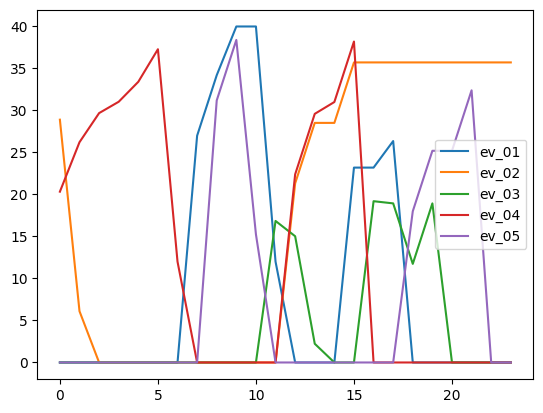

In [27]:
# Check EVs

plt.figure()

for i in test_env.evs:
    plt.plot(test_env.history[-1][str(i)].value * test_env.history[-1][str(i)].capacity_max)
    
plt.legend(['ev_{:02d}'.format(i+1) for i in range(data.vehicle['e_capacity_max'].shape[0])])

plt.show()

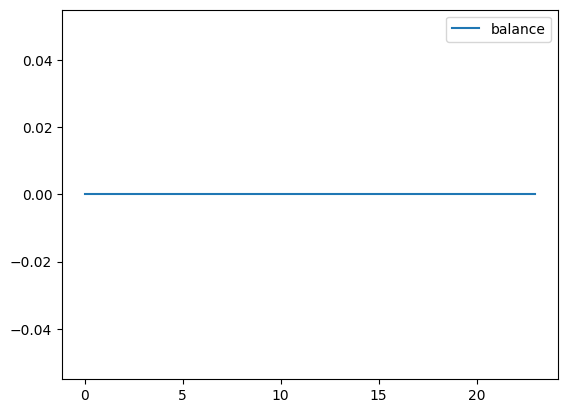

In [28]:
# Plot the balance history

plt.figure()

plt.plot(test_env.balance_history)
plt.legend(['balance'])

plt.show()